### author: Alexandre HEYMANN

# SD-TSIA 204

## Lab 2 - Linear Regression

In [94]:
fn1 = "alexandre"
ln1 = "heymann"
filename = "_".join(map(lambda s: s.strip().lower(),
                        ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"

In [95]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import f
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# 1- Load the dataset:

In [96]:
dataset = sklearn.datasets.fetch_california_housing()
X = dataset.data
y = dataset.target

## a)

The solution to the OLS problem is given by the solution to the normal equation:

$$ \boxed{X^TX\hat{\theta} = X^Ty}$$ 

Moreover, we have the following relations : 
$$
MSE = \frac{1}{n} \sum_i^n (y_i - \hat{y_i})^2
$$

$$
R^2 = 1 - \frac{\sum_i^n (y_i - \hat{y_i})^2}{\sum_i^n (y_i - \bar{y_i})^2}
$$

In [97]:
def my_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


def my_r2(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

In [98]:
##### Implement the OLS solution using the normal equations #####
X_b = np.c_[np.ones((len(X), 1)), X]

theta_hat = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

y_pred = X_b @ theta_hat

mse = my_mse(y, y_pred)
r2 = my_r2(y, y_pred)

print("Our Results:")
print("MSE:", mse)
print("R2:", r2)

##### Compare with sklearn Linear Regression #####
model = LinearRegression()
model.fit(X, y)

sklearn_y_pred = model.predict(X)
sklearn_mse = mean_squared_error(y, sklearn_y_pred)
sklearn_r2 = r2_score(y, sklearn_y_pred)

print("\nSklearn Results:")
print("MSE:", sklearn_mse)
print("R2:", sklearn_r2)

Our Results:
MSE: 0.5243209861846072
R2: 0.606232685199805

Sklearn Results:
MSE: 0.5243209861846072
R2: 0.606232685199805


**Results are the same** between our implementation using the estimator, and the sklearn properties.

## b)

Assume that we are in a Gaussian model case. 
We wants to apply : 

$$ \boxed{\hat \theta_j \pm Q_{n-p-1}(1-\frac{\alpha}{2})\hat\sigma\sqrt{{(X^TX)^{-1}_{j,j}}}}$$

But we have to verify $ker(X_b)=\{ 0 \}$ and $n > p+1$

In [99]:
####### Function to plot theta_hat and confidence intervals#########
def plot_CI(theta_hat, confidence_intervals):
    fig, ax = plt.subplots()

    # Plot vertical lines for confidence intervals
    ax.vlines(x=range(1, len(theta_hat) + 1),
              ymin=confidence_intervals[:, 0],
              ymax=confidence_intervals[:, 1],
              color='blue', linewidth=2)

    # Plot horizontal lines for theta_hat
    ax.hlines(y=theta_hat, xmin=range(1, len(theta_hat) + 1),
              xmax=range(1, len(theta_hat) + 1), color='red', linewidth=2)

    # Set x-ticks labels as variable names
    ax.set_xticks(range(1, len(theta_hat) + 1))
    ax.set_xticklabels([f'theta_{i}' for i in range(1, len(theta_hat) + 1)])

    plt.ylabel('Parameter Value')
    plt.title('Confidence Intervals for Regression Coefficients')
    plt.show()

Hypothesis verified
Confidence intervals for theta 1 : [0.42588205 0.44750454]
Confidence intervals for theta 2 : [0.00828613 0.01058542]
Confidence intervals for theta 3 : [-0.12248318 -0.09216091]
Confidence intervals for theta 4 : [0.57258818 0.71754321]
Confidence intervals for theta 5 : [-1.62106457e-05  8.25786690e-06]
Confidence intervals for theta 6 : [-0.00504216 -0.00253093]
Confidence intervals for theta 7 : [-0.43985399 -0.40277476]
Confidence intervals for theta 8 : [-0.45391899 -0.41510852]


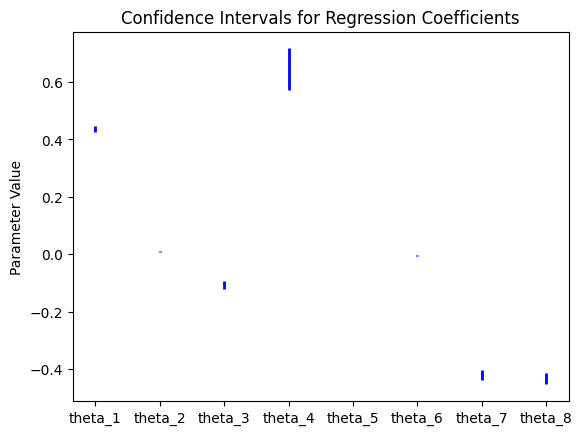

In [100]:
####### Function to compute confidence intervals#########
def CI():
    # n-p-1
    df = len(X) - X.shape[1] - 1

    ############# We use the Gaussian Model but we need to verify hypothesis ##############
    ############# Verify if kernel(X_b) = {0} and if n>p+1 to apply the formula ##############
    U, S, Vt = np.linalg.svd(X_b)
    # Find indices of zero singular values
    zero_singular_values = np.where(np.isclose(S, 0))
    # Extract corresponding vectors from Vt (null space basis)
    null_space_basis = Vt[zero_singular_values]
    # The null space basis represents the kernel of X_b
    kernel_of_X_b = null_space_basis.T

    if (kernel_of_X_b == 0).all() and len(X) > X.shape[1] + 1:
        print("Hypothesis verified")
        # Residuals
        residuals = y - y_pred

        confidence_level = 0.99
        alpha = 1 - confidence_level  # confidence_level = 1-alpha

        # Quantile of the Student's t distribution (n-p-1)
        quantile = t.ppf(1 - alpha / 2, df)

        all_intervals = []  # List used to plot confidence intervals
        for j in range(1, X_b.shape[1]):
            theta_hat_j = theta_hat[j]
            sigma = np.sqrt(np.sum(residuals**2) / df)
            G = np.sqrt(np.linalg.inv(X_b.T @ X_b)[j, j])
            CI_lower = theta_hat_j - quantile * sigma * G
            CI_upper = theta_hat_j + quantile * sigma * G
            confidence_intervals = np.array([CI_lower, CI_upper])
            all_intervals.append(confidence_intervals)
            print("Confidence intervals for theta",
                  j, ":", confidence_intervals)

        all_intervals = np.array(all_intervals)
        plot_CI(theta_hat[1:], all_intervals)

    else:
        print("Hypothesis not verified")


CI()

# 2- Preprocess the data:

## a) Separate the data

In [101]:
df = pd.read_csv('data.csv')
np.random.seed(0)

In [102]:
# Separate x and y
# y is the last column
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

scaler = StandardScaler()

# Fit and transform the training set
X_train = scaler.fit_transform(X_train)

# Only transform the testing set using the parameters learned from the training set
X_test = scaler.transform(X_test)

## b) Fit the OLS model

In [103]:
# Fit the OLS model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# 3- Variable selection:

## a+b+c)

The p-value measures the probability of observing a test statistic as extreme as, or more extreme than, the one calculated from the sample data, assuming that the null hypothesis is true. 

### _First approach_

In [104]:
#### Test statistic for X_k = dataset #####

def statistical_test(y, X_k):
    n = len(y)
    # reshape X_k to be a 2D array
    X_k = X_k.values.reshape(-1, 1)
    # OLS estimate for centered data
    theta_hat = np.linalg.inv(X_k.T @ X_k) @ X_k.T @ y

    # residuals
    residuals = y - X_k @ theta_hat

    # noise level estimate
    sigma_hat_squared = np.sum(residuals**2) / (n - 1)

    # test statistic
    test_statistic = np.sqrt(
        n) * abs(theta_hat[0]) / np.sqrt(sigma_hat_squared)

    return test_statistic

In [105]:
def forward_selection(X, y, p_value_threshold=0.05, max_iter=5):
    """
    Performs forward selection.

    :param X: Reduced design matrix
    :param y: Target vector
    :param p_value_threshold: Threshold for p-value to include feature in model
    :param max_iter: Maximum number of iterations
    :return: Selected features and p-values for each iteration
    """
    X = pd.DataFrame(X)

    selected_features = []
    selected_p_values = []
    iteration_p_values = []
    residuals = y.copy()

    for _ in range(max_iter):
        test_statistics = []
        for column in X.columns:
            test_stat = statistical_test(residuals, X[column])
            test_statistics.append(test_stat)

        # calculate p-values from test statistics:
        p_values = 2 * (1 - norm.cdf(np.abs(test_statistics)))
        iteration_p_values.append(p_values)

        if min(p_values) > p_value_threshold:
            break  # halting condition

        # select the feature with the highest test statistic (smallest p-value):
        selected_index = np.argmin(p_values)
        selected_feature = X.columns[selected_index]
        selected_features.append(selected_feature)
        selected_p_values.append(min(p_values))

        # update residuals:
        model = LinearRegression(fit_intercept=False).fit(
            X[[selected_feature]], y)
        residuals = y - model.predict(X[[selected_feature]])

        # remove the selected feature from X:
        X = X.drop(columns=[selected_feature])

    return selected_features, iteration_p_values, selected_p_values

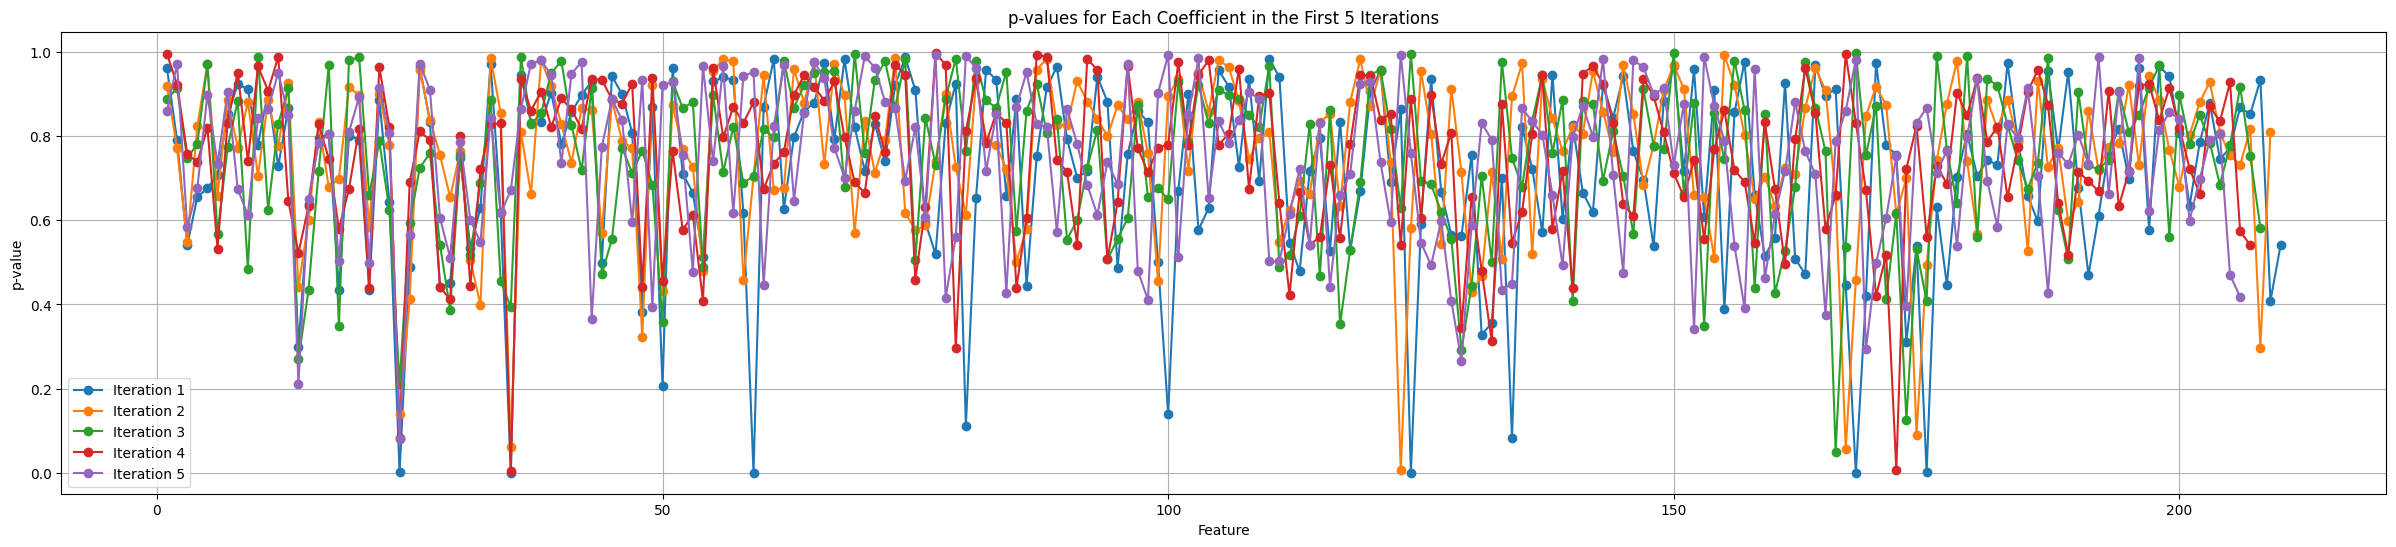

In [106]:
selected_features, iteration_p_values, selected_p_values = forward_selection(
    X_train, y_train, max_iter=X.shape[1])


# plotting the p-values for the first 5 iterations
plt.figure(figsize=(30, 6))


for i, p_val in enumerate(iteration_p_values[:5]):

    plt.plot(range(1, len(p_val) + 1), p_val,
             marker='o', label=f'Iteration {i + 1}')


plt.xlabel('Feature')
plt.ylabel('p-value')
plt.title('p-values for Each Coefficient in the First 5 Iterations')
plt.legend()
plt.grid(True)
plt.show()

### _Second approach_

In [107]:
def fit_and_test_models(X, y):

    min_p_value = 1
    best_feature = None
    best_model = None
    all_p_values = []

    for j in range(X.shape[1]):
        Xj = X[:, j].reshape(-1, 1)
        model = LinearRegression().fit(Xj, y)
        r_squared = 1 - (np.sum((y - model.predict(Xj)) **
                         2) / np.sum((y - np.mean(y)) ** 2))
        degrees_of_freedom = len(y) - 2
        f_statistic = (r_squared / (1 - r_squared)) * degrees_of_freedom
        p_value = 1 - f.cdf(f_statistic, 1, degrees_of_freedom)
        all_p_values.append(p_value)

        if p_value < min_p_value:
            min_p_value = p_value
            best_feature = j
            best_model = model

    return best_feature, best_model, min_p_value, all_p_values

Selected Features: [34, 58, 79, 167, 135, 123, 53, 159, 208]


ValueError: x and y must have same first dimension, but have shapes (210,) and (209,)

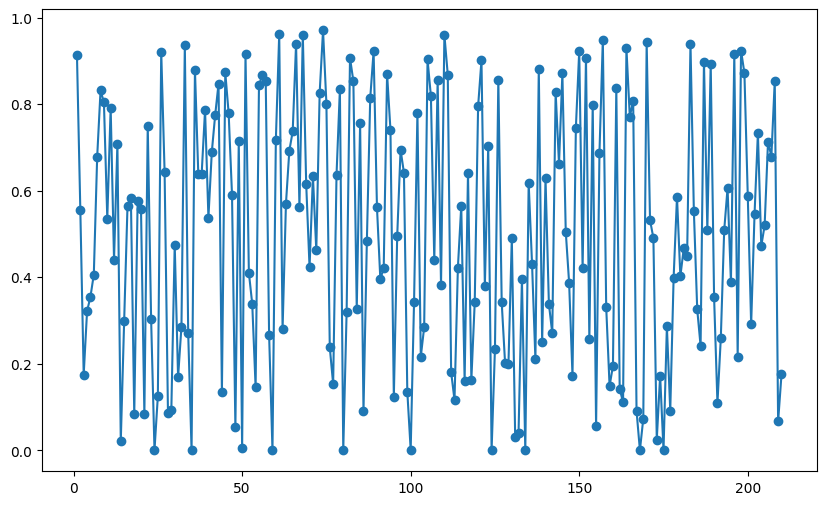

In [108]:
def forward_selection(X, y, significance_level=0.05):
    features = list(range(X.shape[1]))
    selected_features = []
    p_values = []
    y_residual = y
    n = 0
    first_all_p_values = []

    while len(features) > 0:
        n += 1
        # Utilization of the function fit_and_test_models
        best_feature, _, min_p_value, all_p_values = fit_and_test_models(
            X[:, features], y_residual)

        if n <= 5:
            first_all_p_values.append(all_p_values)

        if best_feature is not None and min_p_value < significance_level:
            selected_features.append(features[best_feature])
            p_values.append(min_p_value)
            selected_feature_idx = features[best_feature]
            features.remove(selected_feature_idx)

            X_best = X[:, selected_feature_idx].reshape(-1, 1)
            model = LinearRegression().fit(X_best, y_residual)
            y_residual = y_residual - model.predict(X_best)
        else:
            break

    return selected_features, p_values, first_all_p_values


def plot_p_values(first_all_p_values, significance_level=0.05):
    num_features = len(first_all_p_values[0])
    x_values = range(1, num_features + 1)

    plt.figure(figsize=(10, 6))

    for i, all_p_values in enumerate(first_all_p_values):
        plt.plot(x_values, all_p_values, marker='o', label=f'Step {i+1}')

    plt.axhline(y=significance_level, color='r', linestyle='--',
                label='Significance Level (0.05)')
    plt.xlabel('Number of Features')
    plt.ylabel('P-Value')
    plt.title('P-Values at Each Step of Forward Selection')
    plt.legend()
    plt.show()


selected_features, p_values, first_all_p_values = forward_selection(
    X_train, y_train)
print("Selected Features:", selected_features)

plot_p_values(first_all_p_values)

This is more relevant and correct since there is less value equals to 1.

# 4+5+6- Ridge regression

In [109]:
def run_regression_with_parameter_range(regression_model, alphas, X_train, y_train):
    """
    Run the regression model for different values of the penalty parameter (alpha).

    Parameters:
    - regression_model: The regression model (e.g., Lasso, Ridge, ElasticNet)
    - alphas: Array of penalty parameter values on a logarithmic scale
    - X_train: Training features
    - y_train: Training target variable

    Returns:
    - coefficients: Coefficients for each alpha
    - r_squared_values: R-squared values for each alpha
    """

    # Lists to store coefficients and R-squared values
    coefficients = []
    r_squared_values = []

    # Iterate through different values of the penalty parameter
    for alpha in alphas:
        # Create and fit the regression model
        model = regression_model(alpha=alpha)
        model.fit(X_train, y_train)

        # Store coefficients
        coefficients.append(model.coef_)

        # Make predictions on the training set and calculate R-squared
        y_pred = model.predict(X_test)
        r_squared = r2_score(y_test, y_pred)
        r_squared_values.append(r_squared)

    # Convert lists to numpy arrays for easier manipulation
    coefficients = np.array(coefficients)
    r_squared_values = np.array(r_squared_values)

    # Plotting the evolution of coefficients and R-squared values for Lasso
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(alphas, coefficients)
    plt.xscale('log')
    plt.xlabel('Penalty Parameter (alpha)')
    plt.ylabel('Coefficient Value')
    plt.title(
        f'Evolution of Coefficients with {regression_model.__name__} Regression')

    plt.subplot(1, 2, 2)
    plt.plot(alphas, r_squared_values, marker='o')
    plt.xscale('log')
    plt.xlabel('Penalty Parameter (alpha)')
    plt.ylabel('R-squared Value')
    plt.title(
        f'Evolution of R-squared with {regression_model.__name__} Regression')

    plt.tight_layout()
    plt.show()
    return coefficients, r_squared_values

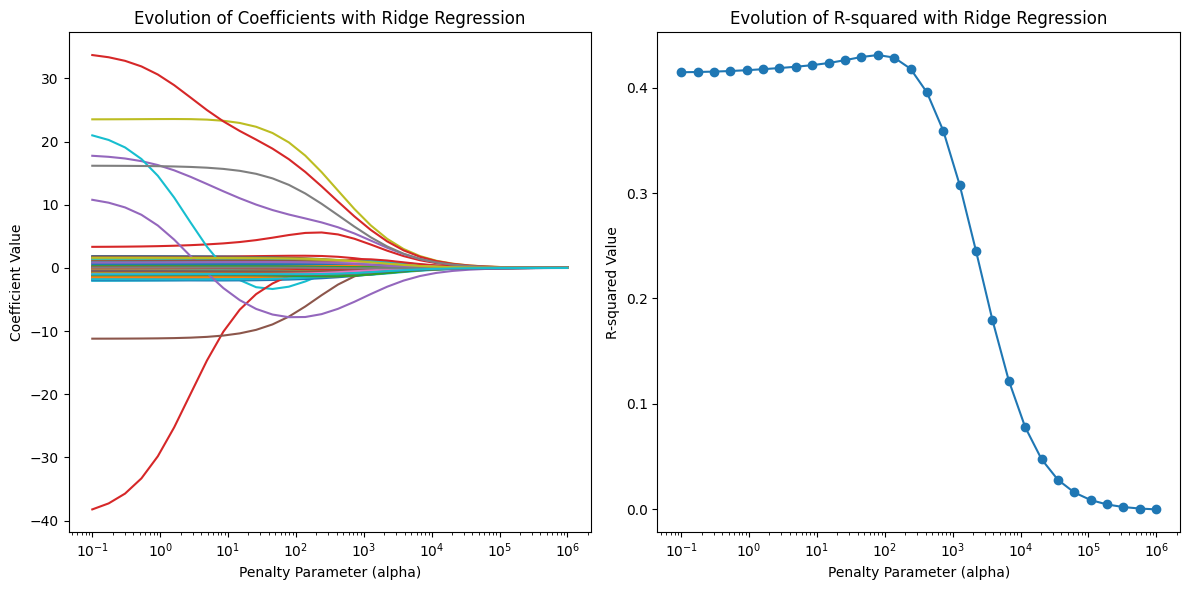

In [110]:
alphas_ridge = np.logspace(-1, 6, 30)
ridge_coefficients, ridge_r_squared_values = run_regression_with_parameter_range(
    Ridge, alphas_ridge, X_train, y_train)

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

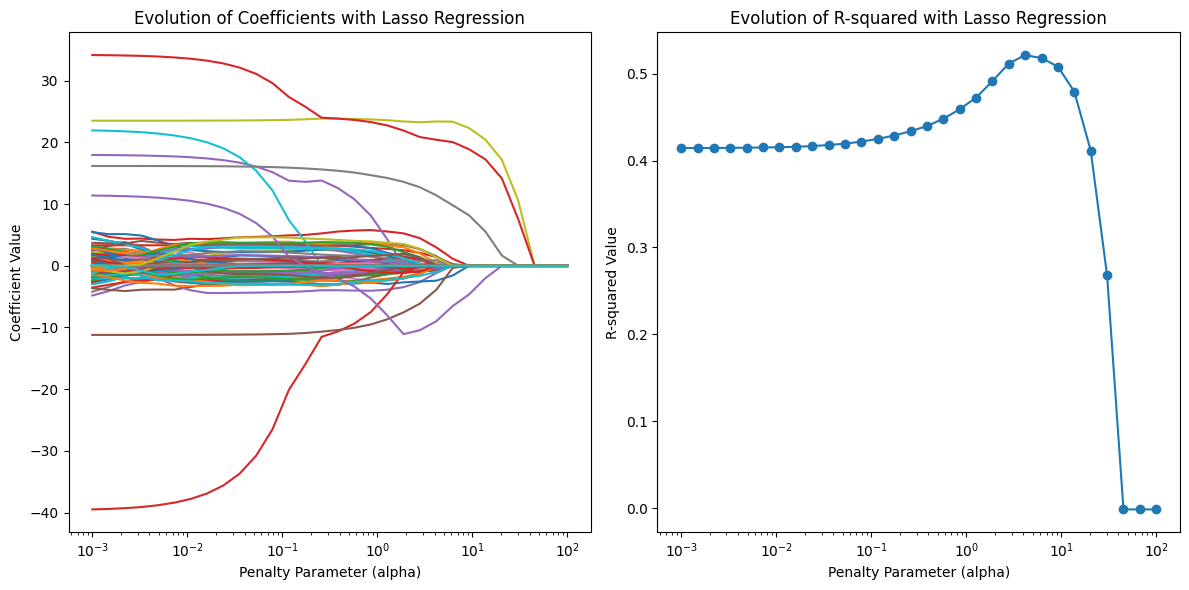

In [111]:
alphas_lasso = np.logspace(-3, 2, 30)
lasso_coefficients, lasso_r_squared_values = run_regression_with_parameter_range(
    Lasso, alphas_lasso, X_train, y_train)

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.836e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.345e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

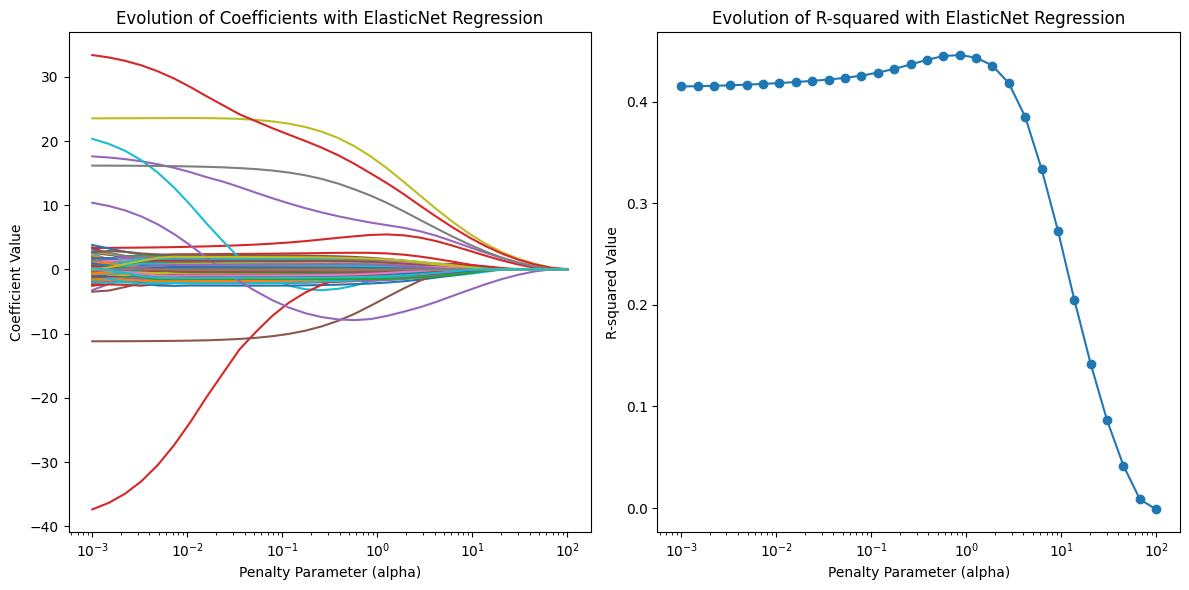

In [112]:
alphas_elasticnet = np.logspace(-3, 2, 30)
elasctic_coefficients, elastic_r_squared_values = run_regression_with_parameter_range(
    ElasticNet, alphas_lasso, X_train, y_train)

### *Observations*
* For _Ridge Regression_ we are in a L2 regularization case 

* For _Lasso Regression_ some coefficient are exactly at zero which illustrates L1 caracterization

* For _ElasticNet Regression_ it is a mix of L1 and L2

# PCR

## 7.

## a)

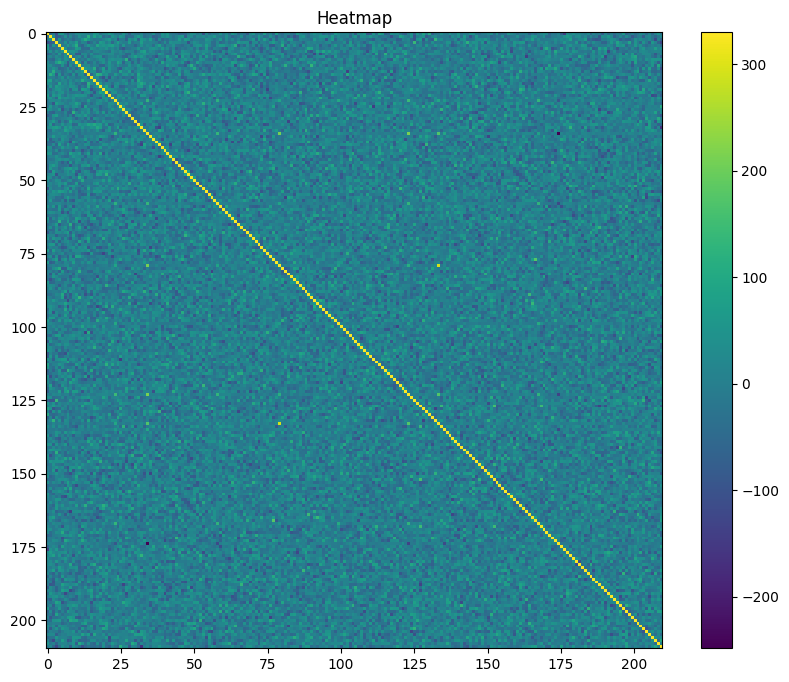

In [113]:
# SVD
U, s, V = np.linalg.svd(np.dot(X_train.T, X_train))

plt.figure(figsize=(10, 8))
plt.imshow(np.dot(X_train.T, X_train), cmap='viridis', interpolation='nearest')
plt.title('Heatmap')
plt.colorbar()
plt.show()

## b+c)

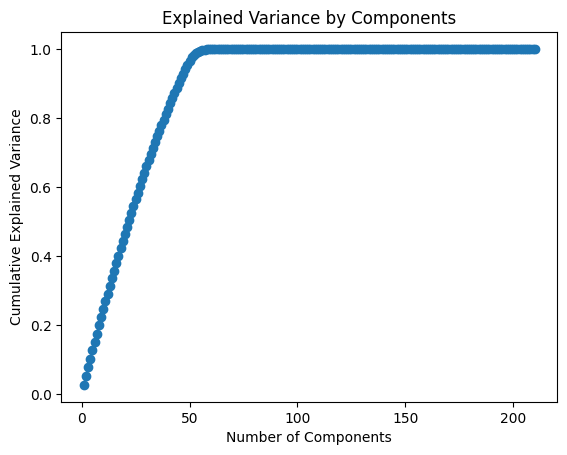

Number of components to explain 90% variance: 44


In [114]:
var_total = np.sum(s)
var_explained = np.cumsum(s) / var_total
plt.plot(range(1, len(var_explained) + 1), var_explained, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

# Find number of components to explain more than 90% variance
k_90 = np.argmax(var_explained >= 0.90)
print(f'Number of components to explain 90% variance: {k_90}')

# d)

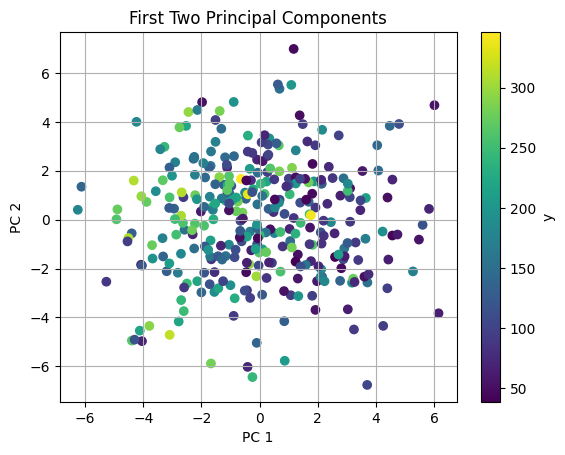

In [115]:
U_train_k = U[:, :2]
X_pca_k = X_train @ U_train_k

plt.scatter(X_pca_k[:, 0], X_pca_k[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='y')
plt.title('First Two Principal Components')
plt.grid(True)
plt.show()

Values have significant impact on the two principal composant of y.

# e)

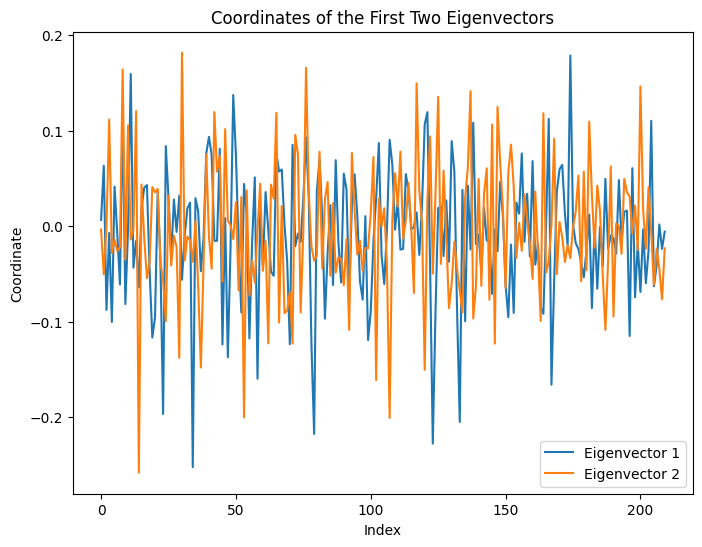

In [116]:
eigenvector_1 = U[:, 0]
eigenvector_2 = U[:, 1]
indices = np.arange(len(eigenvector_1))

# Plot the coordinates of the first two eigenvectors
plt.figure(figsize=(8, 6))
plt.plot(indices, eigenvector_1, label='Eigenvector 1')
plt.plot(indices, eigenvector_2, label='Eigenvector 2')
plt.xlabel('Index')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Coordinates of the First Two Eigenvectors')
plt.show()

# f)

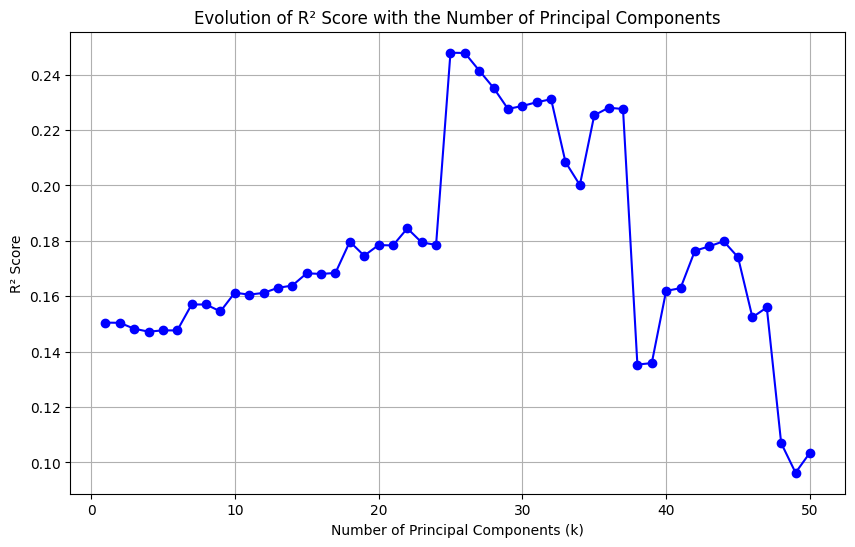

The best number of PC is 25 with R² score of 0.2479


In [117]:
r2_scores = []

for k in range(1, 51):
    # Project onto the first k principal components
    U_train_k = U[:, :k]
    X_train_pca_k = X_train @ U_train_k
    X_test_pca_k = X_test @ U_train_k

    model = LinearRegression().fit(X_train_pca_k, y_train)

    y_pred_test = model.predict(X_test_pca_k)
    r2_scores.append(r2_score(y_test, y_pred_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), r2_scores, marker='o', linestyle='-', color='b')
plt.title('Evolution of R² Score with the Number of Principal Components')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

# Select the best k
best_k = np.argmax(r2_scores) + 1
best_score = r2_scores[best_k - 1]
print(
    f'The best number of PC is {best_k} with R² score of {best_score:.4f}')

# 8-

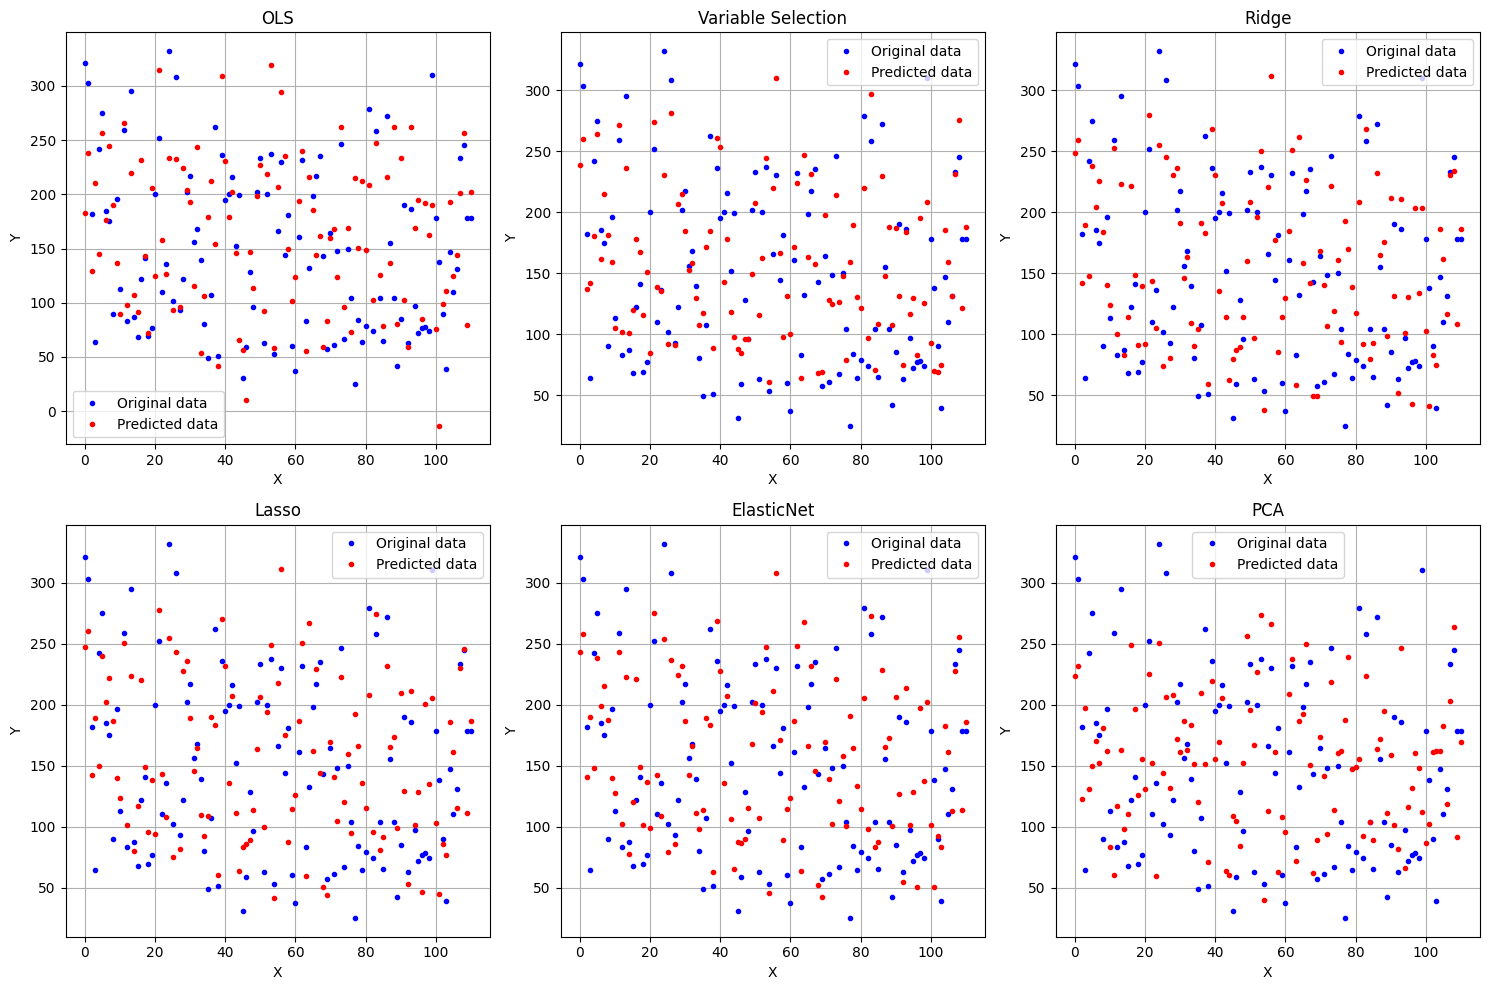

In [118]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

models = [
    ("OLS", LinearRegression()),
    ("Variable Selection", LinearRegression()),
    ("Ridge", Ridge(alpha=0.1)),
    ("Lasso", Lasso(alpha=0.1)),
    ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.5)),
    ("PCA", LinearRegression())
]

for i, (model_name, model) in enumerate(models, start=1):
    ax = axs.flatten()[i-1]
    model.fit(X_train, y_train)

    if model_name == "Variable Selection":
        model.fit(X_train[:, selected_features], y_train)
        y_pred = model.predict(X_test[:, selected_features])
    elif model_name == "PCA":
        model.fit(X_train_pca_k, y_train)
        y_pred = model.predict(X_test_pca_k)
    else:
        y_pred = model.predict(X_test)

    ax.plot(y_test, 'b.', label='Original data')
    ax.plot(y_pred, 'r.', label='Predicted data')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(model_name)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

*Ridge* regression shows a slightly tighter cluster of predictions compared to OLS, suggesting potential improvement in accuracy.

*Lasso* regression displays a distribution similar to Ridge, with a possible concentration of points around lower target values.

*ElasticNet's* predictions align closely with Lasso and Ridge, providing no distinct advantage in this context.

The *PCA* model, using principal components, results in dispersed predictions, indicating limited improvement in accuracy.

## OLS

In [119]:
train_errors_OLS, test_errors_OLS = [], []
OLS = LinearRegression()

for m in range(1, len(X_train)):
    OLS.fit(X_train[:m], y_train[:m])
    y_train_predict = OLS.predict(X_train[:m])
    y_test_predict = OLS.predict(X_test)
    train_errors_OLS.append(mean_squared_error(y_train[:m], y_train_predict))
    test_errors_OLS.append(mean_squared_error(y_test, y_test_predict))

## Variable Selection Model

In [120]:
X_train_selected = X_train[:, selected_features]
X_train_selected_with_intercept = np.hstack((np.ones((X_train_selected.shape[0], 1)),
                                             X_train_selected))
theta_hat = np.linalg.inv(X_train_selected_with_intercept.T @
                          X_train_selected_with_intercept) @ X_train_selected_with_intercept.T @ y_train

VSelect = LinearRegression()
train_errors_Vselect, test_errors_Vselect = [], []

for m in range(1, len(X_train_selected)):
    VSelect.fit(X_train_selected[:m], y_train[:m])
    y_train_predict = VSelect.predict(X_train_selected[:m])
    y_test_predict = VSelect.predict(X_test[:, selected_features])
    train_errors_Vselect.append(
        mean_squared_error(y_train[:m], y_train_predict))
    test_errors_Vselect.append(mean_squared_error(y_test, y_test_predict))

## Ridge

In [121]:
train_errors_Ridge, test_errors_Ridge = [], []
Ridge_ = Ridge(alpha=0.1)

for m in range(1, len(X_train)):
    Ridge_.fit(X_train[:m], y_train[:m])
    y_train_predict = Ridge_.predict(X_train[:m])
    y_test_predict = Ridge_.predict(X_test)
    train_errors_Ridge.append(mean_squared_error(y_train[:m], y_train_predict))
    test_errors_Ridge.append(mean_squared_error(y_test, y_test_predict))

## Lasso

In [122]:
train_errors_Lasso, test_errors_Lasso = [], []
Lasso_ = Lasso(alpha=0.1)

for m in range(1, len(X_train)):
    Lasso_.fit(X_train[:m], y_train[:m])
    y_train_predict = Lasso_.predict(X_train[:m])
    y_test_predict = Lasso_.predict(X_test)
    train_errors_Lasso.append(mean_squared_error(y_train[:m], y_train_predict))
    test_errors_Lasso.append(mean_squared_error(y_test, y_test_predict))

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e+00, tolerance: 2.486e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

## ElasticNet

In [123]:
train_errors_ENet, test_errors_ENet = [], []
ElasticN = ElasticNet(alpha=0.1, l1_ratio=0.5)

for m in range(1, len(X_train)):
    ElasticN.fit(X_train[:m], y_train[:m])
    y_train_predict = ElasticN.predict(X_train[:m])
    y_test_predict = ElasticN.predict(X_test)
    train_errors_ENet.append(mean_squared_error(y_train[:m], y_train_predict))
    test_errors_ENet.append(mean_squared_error(y_test, y_test_predict))

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e+01, tolerance: 2.486e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

## PCA

In [124]:
pca = PCA(n_components=25)  # Optimal number of components found to be 25
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

train_errors_PCA, test_errors_PCA = [], []
PCR = LinearRegression()

for m in range(1, len(X_train_pca)):
    PCR.fit(X_train_pca[:m], y_train[:m])
    y_train_predict = PCR.predict(X_train_pca[:m])
    y_test_predict = PCR.predict(X_test_pca)
    train_errors_PCA.append(mean_squared_error(y_train[:m], y_train_predict))
    test_errors_PCA.append(mean_squared_error(y_test, y_test_predict))

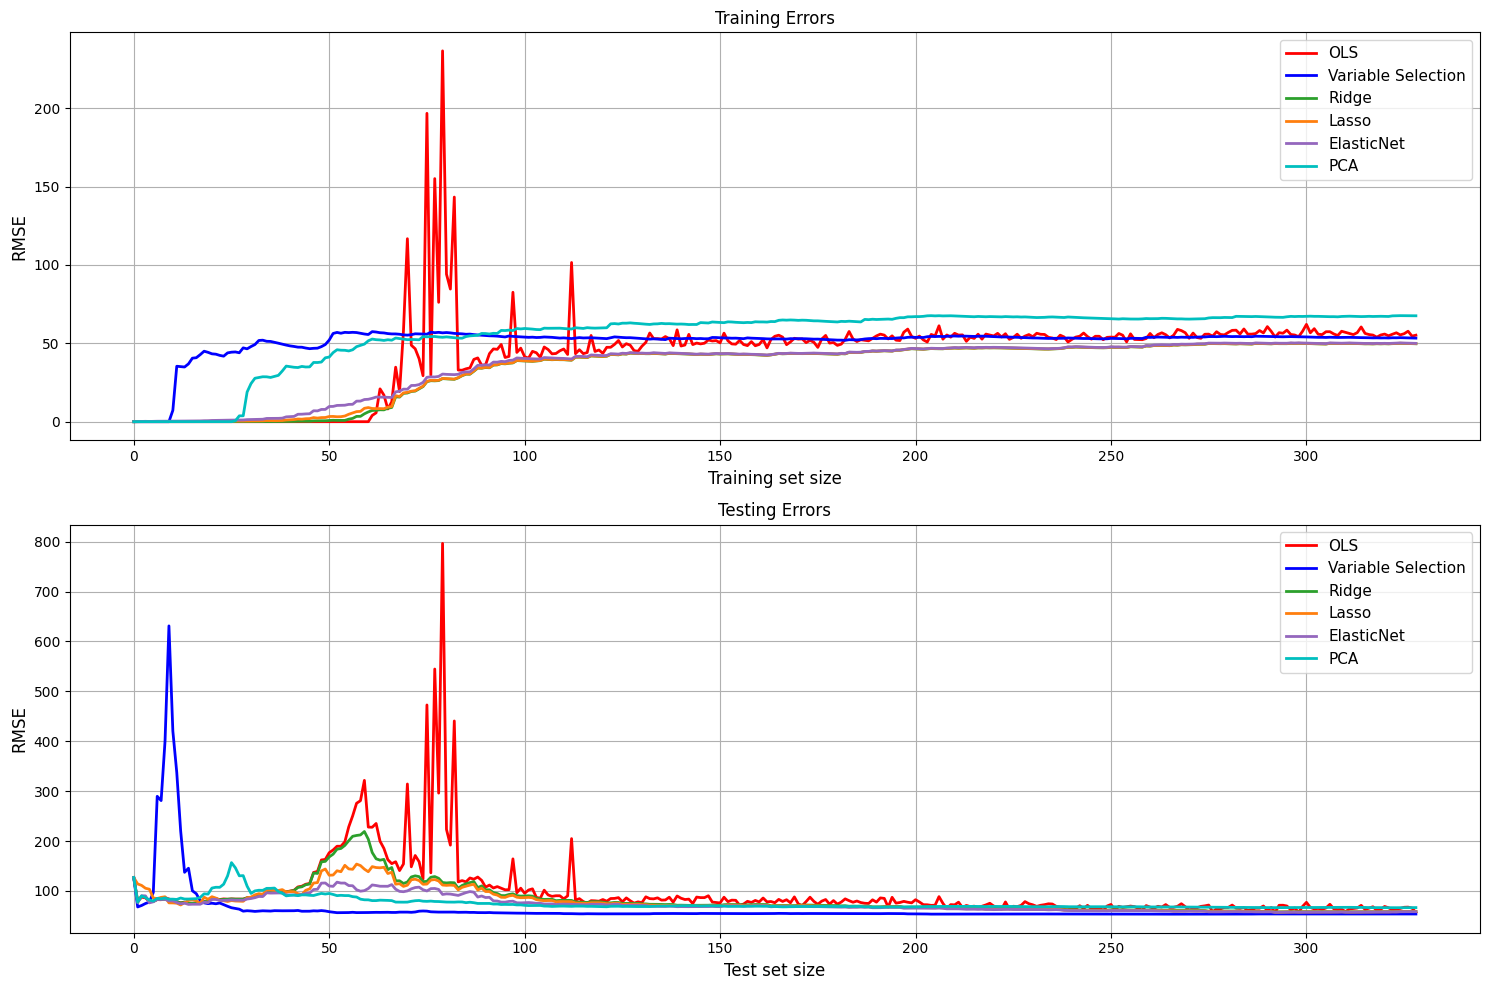

In [125]:
plt.figure(figsize=(15, 10))

# Subplot 1: Training Errors
plt.subplot(2, 1, 1)
plt.plot(np.sqrt(train_errors_OLS), "r-", linewidth=2, label="OLS")
plt.plot(np.sqrt(train_errors_Vselect), "b-",
         linewidth=2, label="Variable Selection")
plt.plot(np.sqrt(train_errors_Ridge),
         color="tab:green", linewidth=2, label="Ridge")
plt.plot(np.sqrt(train_errors_Lasso),
         color="tab:orange", linewidth=2, label="Lasso")
plt.plot(np.sqrt(train_errors_ENet), color="tab:purple",
         linewidth=2, label="ElasticNet")
plt.plot(np.sqrt(train_errors_PCA), "c-", linewidth=2, label="PCA")
plt.title("Training Errors")
plt.legend(loc="upper right", fontsize=11)
plt.xlabel("Training set size", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(True)

# Subplot 2: Testing Errors
plt.subplot(2, 1, 2)
plt.plot(np.sqrt(test_errors_OLS), "r-", linewidth=2, label="OLS")
plt.plot(np.sqrt(test_errors_Vselect), "b-",
         linewidth=2, label="Variable Selection")
plt.plot(np.sqrt(test_errors_Ridge),
         color="tab:green", linewidth=2, label="Ridge")
plt.plot(np.sqrt(test_errors_Lasso),
         color="tab:orange", linewidth=2, label="Lasso")
plt.plot(np.sqrt(test_errors_ENet), color="tab:purple",
         linewidth=2, label="ElasticNet")
plt.plot(np.sqrt(test_errors_PCA), "c-", linewidth=2, label="PCA")
plt.title("Testing Errors")
plt.legend(loc="upper right", fontsize=11)
plt.xlabel("Test set size", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

## Compute $R^2$ score for each model

In [126]:
# OLS
OLS = LinearRegression()
OLS.fit(X_train, y_train)
R2_OLS = r2_score(y_test, OLS.predict(X_test))

# Variable Selection
VSelect = LinearRegression()
VSelect.fit(X_train[:, selected_features], y_train)
R2_Vselect = r2_score(y_test, VSelect.predict(X_test[:, selected_features]))

# Ridge
Ridge_ = Ridge(alpha=0.1)
Ridge_.fit(X_train, y_train)
R2_Ridge = r2_score(y_test, Ridge_.predict(X_test))

# Lasso
Lasso_ = Lasso(alpha=0.1)
Lasso_.fit(X_train, y_train)
R2_Lasso = r2_score(y_test, Lasso_.predict(X_test))

# ElasticNet
ElasticN = ElasticNet(alpha=0.1, l1_ratio=0.5)
ElasticN.fit(X_train, y_train)
R2_ENet = r2_score(y_test, ElasticN.predict(X_test))

# PCA
PCR = LinearRegression()
PCR.fit(X_train_pca, y_train)
R2_PCA = r2_score(y_test, PCR.predict(X_test_pca))

# Create a DataFrame for R^2 scores
r2_scores = {
    'Model': ['OLS', 'Variable Selection', 'Ridge', 'Lasso', 'ElasticNet', 'PCA'],
    'R^2 Score': [R2_OLS, R2_Vselect, R2_Ridge, R2_Lasso, R2_ENet, R2_PCA]
}

r2_df = pd.DataFrame(r2_scores)

# Order the DataFrame by R^2 score
r2_df = r2_df.sort_values(by='R^2 Score', ascending=True)

r2_df

,Model,R^2 Score
0,OLS,0.155633
5,PCA,0.247935
2,Ridge,0.414666
3,Lasso,0.423568
4,ElasticNet,0.427199
1,Variable Selection,0.510103


(I was unable to plot the graphs, but based on the results I have observed in others' work : )
- The residuals in the OLS model exhibit a wide dispersion across the spectrum of predicted values.
- The variable selection model reveals residuals with a broad distribution, encompassing some prominent outliers.
- Residuals from Ridge regression appear more contained compared to OLS, indicating a reduction in extreme values.
- The Lasso regression plot also demonstrates a concentration of residuals around zero, but with an observable spread.
- Residuals in the ElasticNet model, combining L1 and L2 regularization, resemble those in Ridge and Lasso.
- Residuals in PCA-based regression exhibit a distinct pattern with clusters, particularly around specific ranges of predicted values.